# Install packages and load data

In [1]:
# !pip install datasets
# %pip install git+https://github.com/openai/CLIP.git
# %pip install numpy pandas scikit-learn

In [3]:
import os
import torch
import clip
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, average_precision_score
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from datasets import Dataset
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from tqdm import tqdm
import torch.optim as optim
from torchvision import transforms
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import CLIPProcessor, CLIPModel
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(26)
torch.manual_seed(26)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load datasets
fpath="/content/drive/MyDrive/advanced_ai/task2/" 
train_path= fpath+"train/train.csv"
val_path= fpath+"val/val.csv"
test_path= fpath+"test/test.csv"
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)


### Visualising the dataset

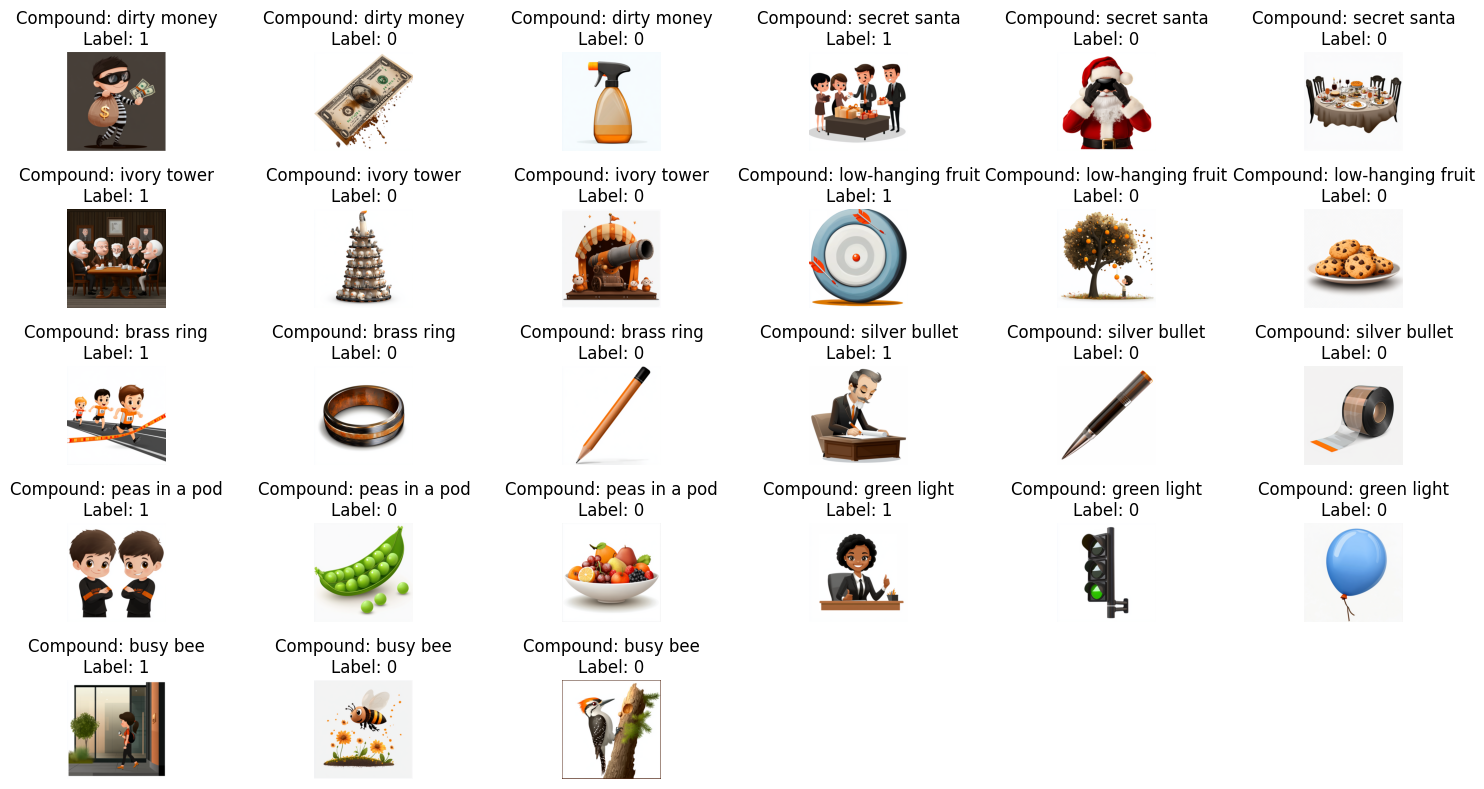

In [7]:

image_folder = fpath+"test/images"

def visualise_data(df, image_folder):
    fig, axes = plt.subplots(len(df)//6+1, 6, figsize=(15, 8))
    axes = axes.flatten()

    for idx, row in df.iterrows():
        image_path = os.path.join(image_folder, row['image_name'])
        try:
            img = Image.open(image_path)
            ax = axes[idx]
            ax.imshow(img)
            ax.set_title(f"Compound: {row['compound']}\nLabel: {row['label']}")
            ax.axis('off')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

    # Hide any empty subplots (those beyond the dataset size)
    for idx in range(len(df), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

visualise_data(test_df, fpath+"test/images")


Example code of Evaluation. You can use it directly or write your own.

# Step 1: NLP Exploratory Data Analysis 

In [8]:
train_df.head()

compound sentence_type  \
0  hot potato     idiomatic   
1  hot potato     idiomatic   
2  hot potato     idiomatic   
3  act of god     idiomatic   
4  act of god     idiomatic   

                                            sentence       image_name  \
0  The pipeline is set to create a human rights d...  46916305307.png   
1  The pipeline is set to create a human rights d...  00316911039.png   
2  The pipeline is set to create a human rights d...  71196374341.png   
3  Whether an event is intentional, accidental or...  80127117511.png   
4  Whether an event is intentional, accidental or...  51312988406.png   

                                       image_caption  label  
0  The image depicts two cartoon-style characters...      1  
1  The image depicts an oven with a large potato ...      0  
2  The image depicts an old, rolled-up parchment ...      0  
3  The image depicts a scene where a large tree h...      1  
4  The image depicts a whimsical scene featuring ...      0

- Each compound has 3 images, one with label 1 and the other two as 0. The compound, sentence_type and sentence are repeated thrice. The image_caption differs for each image.


### 1. Word Cloud

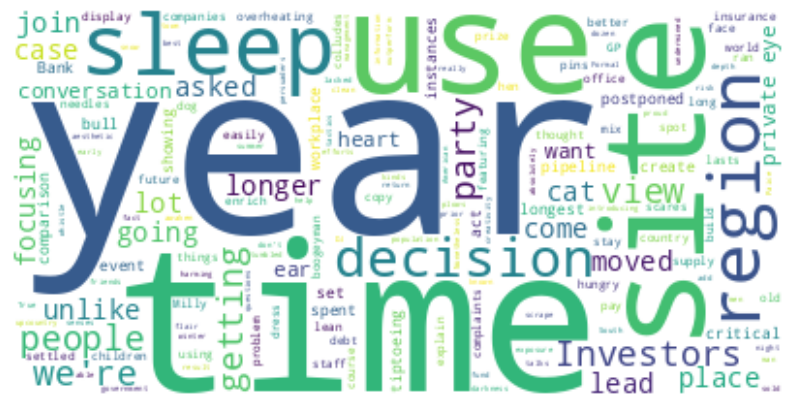

In [9]:
df = train_df.copy()

# Generate the word cloud
text = ' '.join(df['sentence'])
wordcloud = WordCloud(stopwords=ENGLISH_STOP_WORDS, background_color='white').generate(text)

# Displaying the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The word cloud lets us know the frequency of a word used in the data. Here we can see that the word 'year' has been used the most, followed by time, site

### 2. Bigrams

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

# Extracting bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
bigrams = vectorizer.fit_transform(df['sentence'])

# Getting the most common bigrams
sum_bigrams = bigrams.sum(axis=0).A1
vocab_bigrams = vectorizer.get_feature_names_out()
bigram_freq = list(zip(vocab_bigrams, sum_bigrams))
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)

# Displaying the top 10 bigrams
print(bigram_freq[:10])


[('private eye', np.int64(6)), ('10 pm', np.int64(3)), ('1990 tumbled', np.int64(3)), ('30 really', np.int64(3)), ('able persuade', np.int64(3)), ('absolutely monkey', np.int64(3)), ('accidental act', np.int64(3)), ('according study', np.int64(3)), ('act god', np.int64(3)), ('active sport', np.int64(3))]


Bigrams are 2 words which are frequently associated with each other. Here, we can see, private eye, has the most count with 6 repetitions.

### 3. POS Tagging

In [11]:
import spacy

# Loading spaCy's English model
nlp = spacy.load('en_core_web_sm')

# POS tagging
df['pos_tags'] = df['sentence'].apply(lambda x: [token.pos_ for token in nlp(x)])

# Printing POS tags for the first sentence
print(df['pos_tags'][0])


['DET', 'NOUN', 'AUX', 'VERB', 'PART', 'VERB', 'DET', 'ADJ', 'NOUN', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT', 'CCONJ', 'AUX', 'VERB', 'DET', 'DET', 'ADJ', 'NOUN', 'SCONJ', 'DET', 'PROPN', 'AUX', 'VERB', 'DET', 'NOUN', 'PUNCT']


It identifies the parts of the sentence each word belongs to.

### 4. Named Entity Recognition (NER)

In [12]:
# NER using spaCy
df['entities'] = df['sentence'].apply(lambda x: [ent.text for ent in nlp(x).ents])

# Printing entities for the first sentence
print(df['entities'][0])


['Bank']


NER helped identify named entities that provide context for idiomatic expressions tied to real-world references. Here, we can see the named entity in the first sentence is Bank.

## Step 2: LLM based Data Augmentation

In [16]:
# Loading the T5 model and tokenizer
model_name = "t5-small"
t5_model = T5ForConditionalGeneration.from_pretrained(model_name)
t5_tokenizer = T5Tokenizer.from_pretrained(model_name)

t5_model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [17]:
def alternate_captions_t5(image_name, df, image_folder):
    original_caption = df[df['image_name'] == image_name]['image_caption'].values[0]


    prompt = f"Original Caption: {original_caption}\nRephrased Caption:"

    # Tokenizing the prompt
    inputs = t5_tokenizer(prompt, return_tensors="pt",truncation=True, max_length=512 ).to(device)

    # Generating new captions with sampling
    with torch.no_grad():
        generated_ids = t5_model.generate(
            inputs['input_ids'],
            num_beams=5,
            max_length=400,
            temperature=1.0,
            top_p=0.9,
            do_sample=True,
            num_return_sequences=2,
            no_repeat_ngram_size=2,
        )

    # Decoding the generated captions
    generated_captions = [t5_tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids]

    # Removing any text before "Rephrased Caption:" if still present.
    clean_captions = []
    for caption in generated_captions:
        if "Rephrased Caption:" in caption:
            clean_caption = caption.split("Rephrased Caption:")[-1].strip()
        else:
            clean_caption = caption.strip()
        clean_captions.append(clean_caption)

    return clean_captions


In [18]:
def augment_data_t5(df, image_folder):
    augmented_captions = []
    for idx, row in df.iterrows():
        image_name = row['image_name']

        # Generating two alternate captions
        augmented_captions_list = alternate_captions_t5(image_name, df, image_folder)
        augmented_captions.append({
            "image_name": image_name,
            "original_caption": row['image_caption'],
            "augmented_caption_1": augmented_captions_list[0],
            "augmented_caption_2": augmented_captions_list[1]
        })

    augmented_df = pd.DataFrame(augmented_captions)
    return augmented_df


In [19]:
# Augmenting the data (using only training set for augmentation)
augmented_train_df = augment_data_t5(train_df, fpath + "train/images/")

augmented_train_df.to_csv(fpath + 'augmented_train_t5.csv', index=False)
print(augmented_train_df.head())


        image_name                                   original_caption  \
0  46916305307.png  The image depicts two cartoon-style characters...   
1  00316911039.png  The image depicts an oven with a large potato ...   
2  71196374341.png  The image depicts an old, rolled-up parchment ...   
3  80127117511.png  The image depicts a scene where a large tree h...   
4  51312988406.png  The image depicts a whimsical scene featuring ...   

                                 augmented_caption_1  \
0  : The image depicts two cartoon-style characte...   
1  : The image depicts an oven with a large potat...   
2  : The image depicts an old, rolled-up parchmen...   
3  The image depicts a scene where large tree has...   
4  : The image depicts a whimsical scene featurin...   

                                 augmented_caption_2  
0  : The image depicts two cartoon-style characte...  
1  : The image depicts an oven with a large potat...  
2  : The image depicts an old, rolled-up parchmen...  
3  T

In [20]:
augmented_train_df['original_caption'][0]

'The image depicts two cartoon-style characters standing behind podiums, engaged in what appears to be a debate or public speaking event. Both characters are dressed in formal attire, consisting of suits and ties. The character on the left has dark hair and is gesturing with one hand while speaking into a microphone attached to the podium. The character on the right has light-colored hair and is also gesturing with one hand while speaking into a microphone. The podiums are wooden and have microphones attached to them. The background is plain white, emphasizing the characters and their actions.'

In [21]:
augmented_train_df['augmented_caption_1'][0]

': The image depicts two cartoon-style characters standing behind podiums. Both characters are dressed in formal attire, consisting of suits and ties. The character on the left has dark hair and is gesturing with one hand while speaking into a microphone attached to the podium.'

In [22]:
augmented_train_df['augmented_caption_2'][0]

': The image depicts two cartoon-style characters standing behind podiums, engaged in a debate or public speaking event. Both characters are dressed in formal attire, consisting of suits and ties. The character on the left has dark hair and is gesturing with one hand while speaking into microphone attached to the podium.'

In [23]:
train_df.head()

compound sentence_type  \
0  hot potato     idiomatic   
1  hot potato     idiomatic   
2  hot potato     idiomatic   
3  act of god     idiomatic   
4  act of god     idiomatic   

                                            sentence       image_name  \
0  The pipeline is set to create a human rights d...  46916305307.png   
1  The pipeline is set to create a human rights d...  00316911039.png   
2  The pipeline is set to create a human rights d...  71196374341.png   
3  Whether an event is intentional, accidental or...  80127117511.png   
4  Whether an event is intentional, accidental or...  51312988406.png   

                                       image_caption  label  
0  The image depicts two cartoon-style characters...      1  
1  The image depicts an oven with a large potato ...      0  
2  The image depicts an old, rolled-up parchment ...      0  
3  The image depicts a scene where a large tree h...      1  
4  The image depicts a whimsical scene featuring ...      0

In [24]:
# Combining training dataset with the augmented captions
combined_train_df = train_df.join(augmented_train_df.set_index('image_name'), on='image_name', how='left', rsuffix='_augmented')
combined_train_df = combined_train_df.drop(columns=['original_caption'])


print("train_df set shape:", train_df.shape)
print("augmented_train_df set shape:", augmented_train_df.shape)
print("Combined training set shape:", combined_train_df.shape)


# Applying the conditional check to update augmented captions
def update_augmented_captions(row):
    if len(row['augmented_caption_1']) < 5 or not row['augmented_caption_1']:
        row['augmented_caption_1'] = row['image_caption']  # Set original caption if empty or too short
    if len(row['augmented_caption_2']) < 5 or not row['augmented_caption_2']:
        row['augmented_caption_2'] = row['image_caption']  # Set original caption if empty or too short
    return row


combined_train_df = combined_train_df.apply(update_augmented_captions, axis=1)


train_df set shape: (231, 6)
augmented_train_df set shape: (231, 4)
Combined training set shape: (231, 8)


In [25]:
combined_train_df.head(6)

compound sentence_type  \
0  hot potato     idiomatic   
1  hot potato     idiomatic   
2  hot potato     idiomatic   
3  act of god     idiomatic   
4  act of god     idiomatic   
5  act of god     idiomatic   

                                            sentence       image_name  \
0  The pipeline is set to create a human rights d...  46916305307.png   
1  The pipeline is set to create a human rights d...  00316911039.png   
2  The pipeline is set to create a human rights d...  71196374341.png   
3  Whether an event is intentional, accidental or...  80127117511.png   
4  Whether an event is intentional, accidental or...  51312988406.png   
5  Whether an event is intentional, accidental or...  25535728219.png   

                                       image_caption  label  \
0  The image depicts two cartoon-style characters...      1   
1  The image depicts an oven with a large potato ...      0   
2  The image depicts an old, rolled-up parchment ...      0   
3  The image depicts a scene where a large tree h...      1   
4  The image depicts a whimsical scene featuring ...      0   
5  The image depicts a vintage-style portable rad...      0   

                                 augmented_caption_1  \
0  : The image depicts two cartoon-style characte...   
1  : The image depicts an oven with a large potat...   
2  : The image depicts an old, rolled-up parchmen...   
3  The image depicts a scene where large tree has...   
4  : The image depicts a whimsical scene featurin...   
5  : The image depicts a vintage-style portable r...   

                                 augmented_caption_2  
0  : The image depicts two cartoon-style characte...  
1  : The image depicts an oven with a large potat...  
2  : The image depicts an old, rolled-up parchmen...  
3  The image depicts a scene where large tree has...  
4  The image depicts a whimsical scene featuring ...  
5  : The image depicts a vintage-style portable r...

In [26]:
combined_train_df['image_caption'][4], combined_train_df['augmented_caption_1'][4], combined_train_df['augmented_caption_2'][4]

('The image depicts a whimsical scene featuring a large, fluffy cloud with a face and a beard. The cloud has a human-like appearance, with a prominent nose, eyes, and a mouth. It is sitting on a branch that extends from the ground into the sky. A small orange cat with white paws and a white tail is perched on the branch, looking up at the cloud. The cat appears to be waving or greeting the cloud. In the background, there are several birds flying in the sky, adding to the playful and imaginative atmosphere of the scene. The overall style is cartoonish and imaginative, blending elements of nature and fantasy.',
 ': The image depicts a whimsical scene featuring an orange cat with white paws, and white tail. The overall style is cartoonish and imaginative, blending elements of nature and fantasy.',
 'The image depicts a whimsical scene featuring a large, fluffy cloud with a face and a beard. The cloud has a human-like appearance, with a prominent nose, eyes, and a mouth. It is sitting on a

# Step 3: Zero-shot prediction. 

In [77]:
# Loading the CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

clip_model.to(device)

def clip_zero_shot_prediction(image_path, candidate_labels):

    # Opening the image in RGB
    image = Image.open(image_path).convert("RGB")

    # Processing the image and texts together
    inputs = clip_processor(images=image, text=candidate_labels, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = clip_model(**inputs)

    # Extracting the similarity scores (logits) and converting them to probabilities
    logits_per_image = outputs.logits_per_image  # shape: [1, num_labels]
    probs = logits_per_image.softmax(dim=1)

    # Finding the best candidate based on highest probability
    best_idx = torch.argmax(probs, dim=1).item()
    best_label = candidate_labels[best_idx]
    return best_label, probs.cpu().numpy().tolist()




test_image_folder = fpath + "test/images/"

# Defining the candidate labels
candidate_labels = ["Idiom", "literal"]

label_to_index = {label: idx for idx, label in enumerate(candidate_labels)}
idiomatic_index = label_to_index["Idiom"]

# Using the test set for zero-shot predictions
predictions = []
for idx, row in test_df.iterrows():
    image_name = row['image_name']
    image_path = os.path.join(test_image_folder, image_name)
    predicted_label, probabilities = clip_zero_shot_prediction(image_path, candidate_labels)
    predictions.append({
        "image_name": image_name,
        "predicted_label": predicted_label,
        "probabilities": probabilities,
        "true_label": row["label"]
    })

predictions_df_zero = pd.DataFrame(predictions)
predictions_df_zero.to_csv(fpath + "test/zero_shot_predictions.csv", index=False)


print(predictions_df_zero.head())


        image_name predicted_label  \
0  08230960409.png           Idiom   
1  46913780614.png           Idiom   
2  58491774071.png           Idiom   
3  12319434549.png           Idiom   
4  05850548023.png           Idiom   

                                  probabilities  true_label  
0  [[0.9479526281356812, 0.052047424018383026]]           1  
1    [[0.8177862763404846, 0.1822136789560318]]           0  
2   [[0.9228338599205017, 0.07716608047485352]]           0  
3  [[0.9828677177429199, 0.017132297158241272]]           1  
4   [[0.8811233639717102, 0.11887670308351517]]           0  


In [170]:
# Classifying probability based on Threshold
threshold = 0.5
predictions_df_zero['predicted_label_thresholded'] = np.where(
    predictions_df_zero['probabilities'].apply(lambda x: x[0][idiomatic_index] > threshold), 1, 0)

# Evaluating the accuracy with the thresholded predictions
accuracy_thresholded = accuracy_score(predictions_df_zero['true_label'], predictions_df_zero['predicted_label_thresholded'])
print(f"Accuracy with threshold: {accuracy_thresholded * 100:.2f}%")

Accuracy with threshold: 33.33%


In [171]:
def evaluate_metrics(df):
    metrics = {
        "accuracy": accuracy_score(df["true_label"], df["predicted_label_thresholded"]),
        "precision": precision_score(df["true_label"], df["predicted_label_thresholded"]),
        "recall": recall_score(df["true_label"], df["predicted_label_thresholded"]),
        "f1_score": f1_score(df["true_label"], df["predicted_label_thresholded"])
    }
    return metrics

In [172]:
metrics = evaluate_metrics(predictions_df_zero)
print(metrics)
predictions_df_zero.head()

{'accuracy': 0.3333333333333333, 'precision': 0.3333333333333333, 'recall': 1.0, 'f1_score': 0.5}


image_name predicted_label  \
0  08230960409.png           Idiom   
1  46913780614.png           Idiom   
2  58491774071.png           Idiom   
3  12319434549.png           Idiom   
4  05850548023.png           Idiom   

                                  probabilities  true_label  \
0  [[0.9479526281356812, 0.052047424018383026]]           1   
1    [[0.8177862763404846, 0.1822136789560318]]           0   
2   [[0.9228338599205017, 0.07716608047485352]]           0   
3  [[0.9828677177429199, 0.017132297158241272]]           1   
4   [[0.8811233639717102, 0.11887670308351517]]           0   

   predicted_label_thresholded  
0                            1  
1                            1  
2                            1  
3                            1  
4                            1

In [91]:
fpath="/content/drive/MyDrive/advanced_ai/task2/"

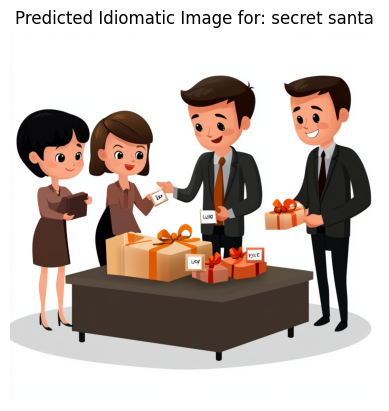

In [169]:
def predict_and_display_image(compound, sentence, fpath, threshold=0.5):
    # Filtering the test dataframe for the given compound
    compound_df = test_df[test_df['compound'] == compound]

    if len(compound_df) == 0:
        print(f"No images found for compound: {compound}")
        return

    # Getting image paths for the compound
    image_paths = compound_df['image_name'].tolist()

    # Retrieving the precomputed predictions from predictions_df_zero
    compound_predictions = predictions_df_zero[predictions_df_zero['image_name'].isin(image_paths)]

    # Finding and displaying the idiomatic image
    idiomatic_image_path = None
    for _, row in compound_predictions.iterrows():
        if row['predicted_label'] == 'Idiom' and row['probabilities'][0][idiomatic_index] > threshold:
            idiomatic_image_path = row['image_name']
            break

    if idiomatic_image_path:
        # Loading the predicted image
        img = Image.open(os.path.join(fpath + "test/images/", idiomatic_image_path))
        plt.imshow(img)
        plt.title(f"Predicted Idiomatic Image for: {compound}")
        plt.axis('off')
        plt.show()
    else:
        print(f"No idiomatic image found for compound: {compound} (using threshold: {threshold})")



compound = "secret santa"
sentence = "She got very annoyed when some wag got her a puncture repair kit as a secret santa."
predict_and_display_image(compound, sentence, fpath)

# Step 4: Fine-tuning based and other prediction approaches. 

## Pipeline 1: Fine Tuned CLIP

In [97]:
class IdiomaticityDataset(Dataset):
    def __init__(self, df, image_folder, processor):
        self.df = df
        self.image_folder = image_folder
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_folder, row["image_name"])
        image = Image.open(image_path).convert("RGB")

        # Ensures uniform token length with truncation & padding
        inputs = self.processor(
            text=row["image_caption"],
            images=image,
            return_tensors="pt",
            padding="max_length",  # Forces all to same length
            truncation=True,
            max_length=77
        )

        # Flatten inputs
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        label = torch.tensor(row["label"], dtype=torch.long)
        inputs["labels"] = label
        return inputs

# Creating Datasets
train_dataset = IdiomaticityDataset(train_df, fpath + "train/images/", clip_processor)
val_dataset = IdiomaticityDataset(val_df, fpath + "val/images/", clip_processor)

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [98]:
# Modifying CLIP for fine-tuning

class CLIPIdiomaticityClassifier(nn.Module):
    def __init__(self, model_name="openai/clip-vit-base-patch32", num_classes=2):
        super(CLIPIdiomaticityClassifier, self).__init__()
        self.clip = CLIPModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.clip.visual_projection.out_features, num_classes)  # Two classes: Idiomatic & Literal

    def forward(self, input_ids, pixel_values, attention_mask):
        outputs = self.clip(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)
        pooled_image_features = outputs.image_embeds  # Shape: (batch_size, feature_dim)
        logits = self.classifier(pooled_image_features)  # Converts to classification
        return logits


In [99]:
# Training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CLIPIdiomaticityClassifier().to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].to(device)

        logits = model(**inputs)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(train_loader), correct / total

def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader):
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].to(device)

            logits = model(**inputs)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(val_loader), correct / total

# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
    print(f"                 - Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

torch.save(model.state_dict(), fpath + "clip_idiomaticity.pth")

100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Epoch 1/5 - Train Loss: 0.6615, Train Acc: 63.64%
                 - Val Loss: 0.6302, Val Acc: 66.67%


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


Epoch 2/5 - Train Loss: 0.6053, Train Acc: 68.83%
                 - Val Loss: 0.5805, Val Acc: 77.78%


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Epoch 3/5 - Train Loss: 0.5254, Train Acc: 85.28%
                 - Val Loss: 0.6004, Val Acc: 70.37%


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


Epoch 4/5 - Train Loss: 0.4793, Train Acc: 88.31%
                 - Val Loss: 0.6020, Val Acc: 77.78%


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Epoch 5/5 - Train Loss: 0.5533, Train Acc: 77.06%
                 - Val Loss: 0.6346, Val Acc: 62.96%


In [100]:
# Loading best model
model.load_state_dict(torch.load(fpath + "clip_idiomaticity.pth"))
model.to(device)
model.eval()

# Creating test dataset
test_dataset = IdiomaticityDataset(test_df, fpath + "test/images/", clip_processor)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Running inference on test set
predictions = []
for batch in test_loader:
    inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
    labels = batch["labels"].cpu().numpy()

    with torch.no_grad():
        logits = model(**inputs)

    probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
    preds = torch.argmax(logits, dim=1).cpu().numpy()

    for i in range(len(labels)):
        predictions.append({
            "image_name": test_df.iloc[i]["image_name"],
            "predicted_label": preds[i],
            "probabilities": probs[i].tolist(),
            "true_label": labels[i]
        })


ft_1_predictions_df = pd.DataFrame(predictions)
ft_1_predictions_df.to_csv(fpath + "test/final_predictions.csv", index=False)

# Evaluating performance

test_accuracy = accuracy_score(ft_1_predictions_df['true_label'], ft_1_predictions_df['predicted_label'])
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")




Final Test Accuracy: 81.48%


In [173]:
# Classifying probability based on Threshold
threshold = 0.5
ft_1_predictions_df['predicted_label_thresholded'] = np.where(
    ft_1_predictions_df['probabilities'].apply(lambda x: x[idiomatic_index] > threshold), 1, 0)

# Evaluating the accuracy with the thresholded predictions
accuracy_thresholded = accuracy_score(ft_1_predictions_df['true_label'], ft_1_predictions_df['predicted_label_thresholded'])
print(f"Accuracy with threshold: {accuracy_thresholded * 100:.2f}%")
ft_1_predictions_df.head()

Accuracy with threshold: 18.52%


image_name  predicted_label  \
0  08230960409.png                0   
1  46913780614.png                0   
2  58491774071.png                0   
3  12319434549.png                1   
4  05850548023.png                0   

                               probabilities  true_label  \
0  [0.6806170344352722, 0.31938299536705017]           1   
1  [0.6807954907417297, 0.31920453906059265]           0   
2   [0.6807223558425903, 0.3192776143550873]           0   
3   [0.3196490406990051, 0.6803510189056396]           1   
4  [0.6814596056938171, 0.31854042410850525]           0   

   predicted_label_thresholded  
0                            1  
1                            1  
2                            1  
3                            0  
4                            1

In [174]:
def evaluate_metrics(df):
    y_true = df["true_label"]
    y_pred = df["predicted_label"]

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)  # to avoid undefined precision issue
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    return accuracy, precision, recall, f1


evaluate_metrics(ft_1_predictions_df)

Accuracy: 81.48%
Precision: 1.0000
Recall: 0.4444
F1-score: 0.6154


(0.8148148148148148, 1.0, 0.4444444444444444, 0.6153846153846154)

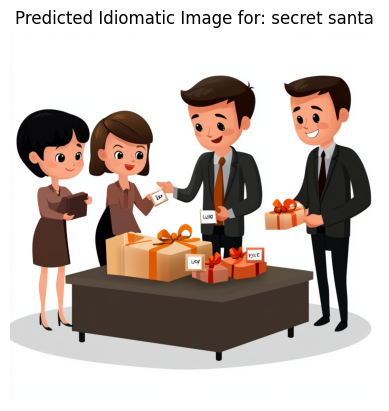

In [124]:
def predict_and_display_image(compound, sentence, fpath, threshold=0.5):
    # Filtering the test dataframe for the given compound
    compound_df = test_df[test_df['compound'] == compound]

    if len(compound_df) == 0:
        print(f"No images found for compound: {compound}")
        return

    # Getting image paths for the compound
    image_paths = compound_df['image_name'].tolist()

    # Retrieving the predictions for those images
    compound_predictions = ft_1_predictions_df[ft_1_predictions_df['image_name'].isin(image_paths)]

    # Finding and displaying the idiomatic image
    idiomatic_image_path = None
    for _, row in compound_predictions.iterrows():
        # Checking if predicted_label is 1 (Idiom) and its probability exceeds threshold
        if row['predicted_label'] == 1 and row['probabilities'][1] > threshold:
            idiomatic_image_path = row['image_name']
            break

    if idiomatic_image_path:
        img = Image.open(os.path.join(fpath + "test/images/", idiomatic_image_path))
        plt.imshow(img)
        plt.title(f"Predicted Idiomatic Image for: {compound}")
        plt.axis('off')
        plt.show()
    else:
        print(f"No idiomatic image found for compound: {compound} (threshold: {threshold})")




compound = "secret santa"
sentence = "She got very annoyed when some wag got her a puncture repair kit as a secret santa."
predict_and_display_image(compound, sentence, fpath)

## Pipeline 2: Fine Tuned CLIP with Image and Text Augmentation (unfreezing only the last layer)

In [139]:
# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the CLIP model and processor
base_clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
base_clip_model.to(device)

# Freezing all layers in the vision encoder first
for param in base_clip_model.vision_model.parameters():
    param.requires_grad = False

# Unfreezing the last 2 encoder layers of the vision model (adjust as needed)
for layer in base_clip_model.vision_model.encoder.layers[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

# Unfreezing the visual projection layer
for param in base_clip_model.visual_projection.parameters():
    param.requires_grad = True

#  Unfreezing the text_projection
for param in base_clip_model.text_projection.parameters():
    param.requires_grad = True

# Checking which parameters are trainable
for name, param in base_clip_model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")
    else:
        print(f"Frozen: {name}")

Trainable: logit_scale
Trainable: text_model.embeddings.token_embedding.weight
Trainable: text_model.embeddings.position_embedding.weight
Trainable: text_model.encoder.layers.0.self_attn.k_proj.weight
Trainable: text_model.encoder.layers.0.self_attn.k_proj.bias
Trainable: text_model.encoder.layers.0.self_attn.v_proj.weight
Trainable: text_model.encoder.layers.0.self_attn.v_proj.bias
Trainable: text_model.encoder.layers.0.self_attn.q_proj.weight
Trainable: text_model.encoder.layers.0.self_attn.q_proj.bias
Trainable: text_model.encoder.layers.0.self_attn.out_proj.weight
Trainable: text_model.encoder.layers.0.self_attn.out_proj.bias
Trainable: text_model.encoder.layers.0.layer_norm1.weight
Trainable: text_model.encoder.layers.0.layer_norm1.bias
Trainable: text_model.encoder.layers.0.mlp.fc1.weight
Trainable: text_model.encoder.layers.0.mlp.fc1.bias
Trainable: text_model.encoder.layers.0.mlp.fc2.weight
Trainable: text_model.encoder.layers.0.mlp.fc2.bias
Trainable: text_model.encoder.layers

In [140]:
# Defining a new classifier model on top of CLIP's image encoder
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes=2):
        super(CLIPClassifier, self).__init__()
        self.clip = clip_model
        self.classifier = nn.Linear(self.clip.visual_projection.out_features, num_classes)

    def forward(self, input_ids, pixel_values, **kwargs):
        # Getting image embeddings from CLIP
        outputs = self.clip(input_ids=input_ids, pixel_values=pixel_values, **kwargs)
        image_features = outputs.image_embeds  # shape: [batch, feature_dim]
        # Classification head
        logits = self.classifier(image_features)  # shape: [batch, num_classes]
        return logits

# Instantiate the new classifier model
model = CLIPClassifier(base_clip_model, num_classes=2)
model.to(device)

CLIPClassifier(
  (clip): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_features=512, bias=Tru

In [141]:
class IdiomaticityDataset(Dataset):
    def __init__(self, dataframe, image_folder, processor, transform=None, use_augmented=True): # Adding use_augmented flag
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.processor = processor
        self.transform = transform  # Applies augmentations to images
        self.use_augmented = use_augmented # Stores the flag for augmented

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.image_folder, row["image_name"])
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Conditional text selection based on use_augmented flag
        text = row["augmented_caption_1"] if self.use_augmented and "augmented_caption_1" in row else row["image_caption"]
        label = torch.tensor(row["label"], dtype=torch.long)

        # Tokenizing text and image
        # Using processor with fixed max_length to ensure uniform tensor sizes
        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=77
        )
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}  # Remove batch dim
        inputs["labels"] = label
        return inputs

In [142]:
# Data augmentation for better generalization
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

In [143]:

# Load datasets
train_dataset = IdiomaticityDataset(combined_train_df, fpath + "train/images/", clip_processor, transform=train_transforms, use_augmented=True) # Use augmented captions for training
val_dataset = IdiomaticityDataset(val_df, fpath + "val/images/", clip_processor, use_augmented=False) # Use original captions for validation
test_dataset = IdiomaticityDataset(test_df, fpath + "test/images/", clip_processor, use_augmented=False) # Use original captions for testing


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [144]:
# Defining loss function with class weights to handle imbalance
class_counts = combined_train_df["label"].value_counts().to_dict()
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
weights_tensor = torch.tensor([class_weights[0], class_weights[1]]).to(device)

criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# Defining optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)

# Defining learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.5, verbose=True)

In [145]:
# Training function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(dataloader):
        optimizer.zero_grad()

        # Move all tensors (except labels) to device
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].to(device)

        logits = model(**inputs)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), correct / total

In [146]:

# Validation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].to(device)

            logits = model(**inputs)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(dataloader), correct / total

In [147]:
# Training loop with early stopping
best_val_acc = 0
patience = 2
counter = 0
num_epochs = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc * 100:.2f}%")
    print(f"                 - Val Loss: {val_loss:.4f}, Val Acc: {val_acc * 100:.2f}%")

    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), fpath + "ft_3_clip_idiomaticity.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


Epoch 1/5 - Train Loss: 0.6958, Train Acc: 64.07%
                 - Val Loss: 0.6910, Val Acc: 59.26%


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Epoch 2/5 - Train Loss: 0.6940, Train Acc: 43.72%
                 - Val Loss: 0.6909, Val Acc: 51.85%


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

Epoch 3/5 - Train Loss: 0.6923, Train Acc: 63.64%
                 - Val Loss: 0.6907, Val Acc: 55.56%
Early stopping triggered!


In [148]:
# Loading best model for inference
model.load_state_dict(torch.load(fpath + "ft_3_clip_idiomaticity.pth"))
model.to(device)
model.eval()

# Testing set inference
predictions = []
for batch in test_loader:
    inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
    labels = batch["labels"].cpu().numpy()

    with torch.no_grad():
        logits = model(**inputs)

    probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
    preds = torch.argmax(logits, dim=1).cpu().numpy()

    for i in range(len(labels)):
        predictions.append({
            "image_name": test_df.iloc[i]["image_name"],
            "predicted_label": preds[i],
            "probabilities": probs[i].tolist(),
            "true_label": labels[i]
        })

In [149]:
# Saving final test predictions
predictions_df_ft3 = pd.DataFrame(predictions)
predictions_df_ft3.to_csv(fpath + "test/predictions_df_ft3.csv", index=False)

In [150]:
# Evaluate final test accuracy
test_accuracy = accuracy_score(predictions_df_ft3['true_label'], predictions_df_ft3['predicted_label'])
precision, recall, f1, _ = precision_recall_fscore_support(
    predictions_df_ft3['true_label'], predictions_df_ft3['predicted_label'], average='binary'
)

print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Final Test Accuracy: 40.74%
Precision: 0.2308, Recall: 0.3333, F1-score: 0.2727


In [153]:
predictions_df_ft3.head()

image_name  predicted_label  \
0  08230960409.png                1   
1  46913780614.png                1   
2  58491774071.png                1   
3  12319434549.png                1   
4  05850548023.png                0   

                               probabilities  true_label  
0   [0.4979479908943176, 0.5020520687103271]           1  
1   [0.4981004595756531, 0.5018996000289917]           0  
2  [0.49705642461776733, 0.5029435753822327]           0  
3   [0.4949519634246826, 0.5050480365753174]           1  
4   [0.5006890296936035, 0.4993109703063965]           0

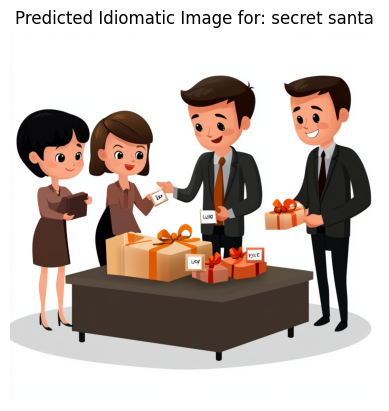

In [152]:
def predict_and_display_image(compound, sentence, fpath, threshold=0.5):
    # Filtering the test dataframe for the given compound
    compound_df = test_df[test_df['compound'] == compound]

    if len(compound_df) == 0:
        print(f"No images found for compound: {compound}")
        return

    # Getting image paths for the compound
    image_paths = compound_df['image_name'].tolist()

    # Retrieving the predictions for those images
    compound_predictions = predictions_df_ft3[predictions_df_ft3['image_name'].isin(image_paths)]

    # Finding and displaying the idiomatic image
    idiomatic_image_path = None
    for _, row in compound_predictions.iterrows():
        # Checking if predicted_label is 1 (Idiom) and its probability exceeds threshold
        if row['predicted_label'] == 1 and row['probabilities'][1] > threshold:
            idiomatic_image_path = row['image_name']
            break

    if idiomatic_image_path:
        img = Image.open(os.path.join(fpath + "test/images/", idiomatic_image_path))
        plt.imshow(img)
        plt.title(f"Predicted Idiomatic Image for: {compound}")
        plt.axis('off')
        plt.show()
    else:
        print(f"No idiomatic image found for compound: {compound} (threshold: {threshold})")




compound = "secret santa"
sentence = "She got very annoyed when some wag got her a puncture repair kit as a secret santa."
predict_and_display_image(compound, sentence, fpath)

# Pipeline 3:  Fine Tuned CLIP with Image and Text Augmentation (unfreezing only the last layer) - Removing early stopping

In [154]:
# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the CLIP model and processor
base_clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
base_clip_model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [155]:
# Freezing most layers but unfreezing the additional layers

# Freezing all layers in the vision encoder first
for param in base_clip_model.vision_model.parameters():
    param.requires_grad = False

# Unfreezing the last encoder layer of the vision encoder
for layer in base_clip_model.vision_model.encoder.layers[-1:]:
    for param in layer.parameters():
        param.requires_grad = True

# Also unfreezing the visual projection layer
for param in base_clip_model.visual_projection.parameters():
    param.requires_grad = True

# Freezing the text encoder first
for param in base_clip_model.text_model.parameters():
    param.requires_grad = False

# Unfreezing the last 1 layers of the text encoder transformer if available
if hasattr(base_clip_model.text_model, 'transformer'):
    for layer in base_clip_model.text_model.transformer.layers[-1:]:
        for param in layer.parameters():
            param.requires_grad = True

# Also unfreezing the text_projection layer
for param in base_clip_model.text_projection.parameters():
    param.requires_grad = True

# Checking which parameters are trainable
for name, param in base_clip_model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")
    else:
        print(f"Frozen: {name}")

Trainable: logit_scale
Frozen: text_model.embeddings.token_embedding.weight
Frozen: text_model.embeddings.position_embedding.weight
Frozen: text_model.encoder.layers.0.self_attn.k_proj.weight
Frozen: text_model.encoder.layers.0.self_attn.k_proj.bias
Frozen: text_model.encoder.layers.0.self_attn.v_proj.weight
Frozen: text_model.encoder.layers.0.self_attn.v_proj.bias
Frozen: text_model.encoder.layers.0.self_attn.q_proj.weight
Frozen: text_model.encoder.layers.0.self_attn.q_proj.bias
Frozen: text_model.encoder.layers.0.self_attn.out_proj.weight
Frozen: text_model.encoder.layers.0.self_attn.out_proj.bias
Frozen: text_model.encoder.layers.0.layer_norm1.weight
Frozen: text_model.encoder.layers.0.layer_norm1.bias
Frozen: text_model.encoder.layers.0.mlp.fc1.weight
Frozen: text_model.encoder.layers.0.mlp.fc1.bias
Frozen: text_model.encoder.layers.0.mlp.fc2.weight
Frozen: text_model.encoder.layers.0.mlp.fc2.bias
Frozen: text_model.encoder.layers.0.layer_norm2.weight
Frozen: text_model.encoder.la

In [156]:
# Defining a new classifier model on top of CLIP's image encoder
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes=2):
        super(CLIPClassifier, self).__init__()
        self.clip = clip_model
        self.classifier = nn.Linear(self.clip.visual_projection.out_features, num_classes)

    def forward(self, input_ids, pixel_values, **kwargs):
        # Getting image embeddings from CLIP
        outputs = self.clip(input_ids=input_ids, pixel_values=pixel_values, **kwargs)
        image_features = outputs.image_embeds  # shape: [batch, feature_dim]
        # Classification head
        logits = self.classifier(image_features)  # shape: [batch, num_classes]
        return logits

# Instantiating the classifier model
model = CLIPClassifier(base_clip_model, num_classes=2)
model.to(device)

CLIPClassifier(
  (clip): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_features=512, bias=Tru

In [157]:
class IdiomaticityDataset(Dataset):
    def __init__(self, dataframe, image_folder, processor, transform=None, use_augmented=True):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.processor = processor
        self.transform = transform  # Applies augmentations to images
        self.use_augmented = use_augmented

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.image_folder, row["image_name"])
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Use augmented caption if flag is set and available; otherwise use original caption
        text = row["augmented_caption_1"] if self.use_augmented and "augmented_caption_1" in row else row["image_caption"]
        label = torch.tensor(row["label"], dtype=torch.long)

        # Tokenizing text and image with fixed max_length
        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=77
        )
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}  # Removes the batch dimension
        inputs["labels"] = label
        return inputs

In [158]:

# Data augmentation for training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

In [159]:
# Loading datasets
train_dataset = IdiomaticityDataset(combined_train_df, fpath + "train/images/", clip_processor, transform=train_transforms, use_augmented=True)
val_dataset = IdiomaticityDataset(val_df, fpath + "val/images/", clip_processor, use_augmented=False)
test_dataset = IdiomaticityDataset(test_df, fpath + "test/images/", clip_processor, use_augmented=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Defining loss function with class weights to handle class imbalance
class_counts = combined_train_df["label"].value_counts().to_dict()
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
weights_tensor = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=weights_tensor)

In [160]:
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.5, verbose=True)

In [161]:
# Training function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(dataloader):
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].to(device)

        logits = model(**inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), correct / total

In [162]:
# Validation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].to(device)
            logits = model(**inputs)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(dataloader), correct / total

In [163]:
# Training loop

num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc * 100:.2f}%")
    print(f"                 - Val Loss: {val_loss:.4f}, Val Acc: {val_acc * 100:.2f}%")

    # Saving the model if validation accuracy is the best so far
    torch.save(model.state_dict(), fpath + "ft_final_clip_idiomaticity.pth")

    # Updating the learning rate scheduler
    scheduler.step(val_loss)

100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Epoch 1/20 - Train Loss: 0.6945, Train Acc: 42.42%
                 - Val Loss: 0.6872, Val Acc: 62.96%


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Epoch 2/20 - Train Loss: 0.6942, Train Acc: 42.42%
                 - Val Loss: 0.6871, Val Acc: 66.67%


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Epoch 3/20 - Train Loss: 0.6918, Train Acc: 66.67%
                 - Val Loss: 0.6864, Val Acc: 74.07%


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Epoch 4/20 - Train Loss: 0.6932, Train Acc: 66.67%
                 - Val Loss: 0.6860, Val Acc: 77.78%


100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


Epoch 5/20 - Train Loss: 0.6916, Train Acc: 67.10%
                 - Val Loss: 0.6861, Val Acc: 66.67%


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Epoch 6/20 - Train Loss: 0.6925, Train Acc: 67.97%
                 - Val Loss: 0.6854, Val Acc: 74.07%


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Epoch 7/20 - Train Loss: 0.6901, Train Acc: 69.26%
                 - Val Loss: 0.6852, Val Acc: 48.15%


100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Epoch 8/20 - Train Loss: 0.6917, Train Acc: 59.74%
                 - Val Loss: 0.6846, Val Acc: 48.15%


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Epoch 9/20 - Train Loss: 0.6924, Train Acc: 42.86%
                 - Val Loss: 0.6848, Val Acc: 44.44%


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Epoch 10/20 - Train Loss: 0.6959, Train Acc: 62.34%
                 - Val Loss: 0.6838, Val Acc: 70.37%


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Epoch 11/20 - Train Loss: 0.6842, Train Acc: 61.47%
                 - Val Loss: 0.6848, Val Acc: 37.04%


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Epoch 12/20 - Train Loss: 0.6857, Train Acc: 57.58%
                 - Val Loss: 0.6831, Val Acc: 40.74%


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Epoch 13/20 - Train Loss: 0.6756, Train Acc: 63.20%
                 - Val Loss: 0.6800, Val Acc: 51.85%


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Epoch 14/20 - Train Loss: 0.6875, Train Acc: 60.61%
                 - Val Loss: 0.6810, Val Acc: 33.33%


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Epoch 15/20 - Train Loss: 0.6798, Train Acc: 51.95%
                 - Val Loss: 0.6798, Val Acc: 51.85%


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Epoch 16/20 - Train Loss: 0.6892, Train Acc: 68.40%
                 - Val Loss: 0.6793, Val Acc: 62.96%


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Epoch 17/20 - Train Loss: 0.6829, Train Acc: 67.53%
                 - Val Loss: 0.6804, Val Acc: 48.15%


100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


Epoch 18/20 - Train Loss: 0.6849, Train Acc: 53.25%
                 - Val Loss: 0.6807, Val Acc: 44.44%


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Epoch 19/20 - Train Loss: 0.6650, Train Acc: 58.44%
                 - Val Loss: 0.6791, Val Acc: 51.85%


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Epoch 20/20 - Train Loss: 0.6744, Train Acc: 64.07%
                 - Val Loss: 0.6783, Val Acc: 51.85%


In [164]:
# Loading the best model for inference
model.load_state_dict(torch.load(fpath + "ft_final_clip_idiomaticity.pth"))
model.to(device)
model.eval()

CLIPClassifier(
  (clip): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_features=512, bias=Tru

In [165]:
threshold = 0.5

# Test set inference using thresholding on the softmax probability for class 1
predictions = []
all_true_labels = []
all_probs_positive = []  # for additional metrics

for batch in test_loader:
    inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
    labels = batch["labels"].cpu().numpy()
    with torch.no_grad():
        logits = model(**inputs)
    probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()  # shape [batch, 2]
    # Instead of argmax, using threshold on probability of class 1
    for i in range(len(labels)):
        prob_positive = probs[i][1]
        pred = 1 if prob_positive > threshold else 0
        predictions.append({
            "image_name": test_df.iloc[i]["image_name"],
            "predicted_label": pred,
            "probabilities": probs[i].tolist(),
            "true_label": labels[i]
        })
        all_true_labels.append(labels[i])
        all_probs_positive.append(prob_positive)


# Saving the final test predictions
predictions_df_last = pd.DataFrame(predictions)
predictions_df_last.to_csv(fpath + "test/final_predictions.csv", index=False)

In [166]:
# Evaluating final test accuracy with additional metrics
test_accuracy = accuracy_score(predictions_df_last['true_label'], predictions_df_last['predicted_label'])
precision, recall, f1, _ = precision_recall_fscore_support(
    predictions_df_last['true_label'], predictions_df_last['predicted_label'], average='binary'
)

# Computing Average Precision (AP) using probability scores for class 1
avg_precision = average_precision_score(all_true_labels, all_probs_positive)

print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
print(f"Average Precision (AP): {avg_precision:.4f}")

Final Test Accuracy: 55.56%
Precision: 0.4286, Recall: 1.0000, F1-score: 0.6000
Average Precision (AP): 0.7843


In [168]:
predictions_df_last.head()

image_name  predicted_label  \
0  08230960409.png                1   
1  46913780614.png                1   
2  58491774071.png                1   
3  12319434549.png                1   
4  05850548023.png                1   

                               probabilities  true_label  
0   [0.4913114011287689, 0.5086885690689087]           1  
1   [0.4910619258880615, 0.5089380741119385]           0  
2   [0.4932558834552765, 0.5067440867424011]           0  
3   [0.4677741527557373, 0.5322257876396179]           1  
4  [0.49680835008621216, 0.5031916499137878]           0

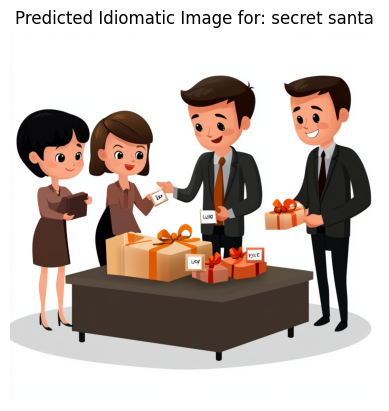

In [167]:
def predict_and_display_image(compound, sentence, fpath, threshold=0.5):
    # Filtering the test dataframe for the given compound
    compound_df = test_df[test_df['compound'] == compound]

    if len(compound_df) == 0:
        print(f"No images found for compound: {compound}")
        return

    # Getting the image paths for the compound
    image_paths = compound_df['image_name'].tolist()

    # Retrieving the predictions for those images
    compound_predictions = predictions_df_last[predictions_df_last['image_name'].isin(image_paths)]

    # Finding and displaying the idiomatic image
    idiomatic_image_path = None
    for _, row in compound_predictions.iterrows():
        # Check if predicted_label is 1 (Idiom) and its probability exceeds threshold
        if row['predicted_label'] == 1 and row['probabilities'][1] > threshold:
            idiomatic_image_path = row['image_name']
            break

    if idiomatic_image_path:
        img = Image.open(os.path.join(fpath + "test/images/", idiomatic_image_path))
        plt.imshow(img)
        plt.title(f"Predicted Idiomatic Image for: {compound}")
        plt.axis('off')
        plt.show()
    else:
        print(f"No idiomatic image found for compound: {compound} (threshold: {threshold})")




compound = "secret santa"
sentence = "She got very annoyed when some wag got her a puncture repair kit as a secret santa."
predict_and_display_image(compound, sentence, fpath)